## ChebPE


This jupyter notebook presents a modified version of the ChebAE algorithm from [arXiv:2207.08628](https://arxiv.org/abs/2207.08628). Say $a \in [0,1]$ is an amplitude. Given an oracle that for a parameter $k$ tosses a coin that comes up heads with probability
$$\sin^2( (2k+1) \arcsin(a) )  $$
at cost $k$, the objective is to estimate the probability $a^2$ with minimal cost. The ChebAE algorithm estimates the amplitude $a$. The ChebPE algorithm presented in this notebook modifies ChebAE to estimate the probability $p := a^2$ instead.

It was observed that $\sin^2( (2k+1) \arcsin(a) ) = T^2_n(a)$ where $n = 2k+1$, where $T_n$ is the $n$'th Chebyshev polynomial of the first kind. In this modified version we are hence interested in $T^2_n(\sqrt{p})$. Fortunately, this function behaves rather similarly to $T^2_n(a)$: the function oscillates as a function of $p$, and the slope of the oscillations, though varying with $p$, is roughly linear in $n$. This is the central assumption that goes into the design of the 'early-late' condition. In ChebPE, we are 'late' whenever the following holds:
$$ \varepsilon_\text{max}^{T^2} \cdot \frac{p_\text{max} - p_\text{min}}{|T^2_n(\sqrt{p_\text{max}}) - T^2_n(\sqrt{p_\text{min}})|} \leq \nu \varepsilon$$
where $[p_\text{min},p_\text{max}]$ is the current confidence interval on $p$, $\varepsilon$ is the desired final accuracy, $\nu$ is a hyperparameter, and $\varepsilon_\text{max}^{T^2}$ is the largest possible error in our estimate of $T^2(\sqrt{p})$ using $N_\text{shots}$ many shots. Once the late condition holds then $N_{shots}$ might be significantly more shots than necessary to get the desired accuracy, so it makes sense to take the shots one at a time rather than in bunches of $N_\text{shots}$. The parameter $\nu$ governs how 'cautiously' we trigger this condition. Optimizing $\nu$ was the primary source of the speedup in ChebAE.



In [1]:
import numpy as np
from scipy.special import eval_chebyt as cheb
from scipy.stats import binom
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import json, os

# Subroutines

In [2]:

def invert_T2rootp(T2,n,p_int):
    """ Given T2, find a p such that T2 = T^2_n( sqrt(p) ). There may be multiple solutions so select the closest one to p_int. """
    
    # Just map to the invert function from ChebAE.
    # See that function's implementation for detailed comments.
    theta_int = np.arccos(np.sqrt(p_int))
    c = np.pi/(2*n)
    t = np.floor(theta_int/c)
    
    if t % 2 == 0: theta = np.arccos(2*T2-1)/(2*n)
    else: theta = 2*c - np.arccos(2*T2-1)/(2*n)

    k = t//2
    theta += np.pi*k/n
    return np.cos(theta)**2


def find_next_k(p_min, p_max, min_k=0):
    """Find a k >= min_k such that when n = 2k+1 the function T^2_n(sqrt(p)) has no extrema on the interval [p_min, p_max]."""

    # Step 1: convert to theta.
    theta_lo = np.arccos(np.sqrt(p_max))
    theta_hi = np.arccos(np.sqrt(p_min))
    
    # Step 2: get highest possible degree.
    n = int((np.pi/2)/(theta_hi-theta_lo))
    if n % 2 == 0: n += 1 # make it odd

    # Step 3: search for the highest degree without any extrema.
    while n > 2*min_k+1:
        if int(2*n*theta_lo/np.pi) == int(2*n*theta_hi/np.pi):
            return (n-1)//2 # Done!
        n -= 2           
    return None # Couldn't find a degree > min_deg.


def max_error_cp(delta, Nshots):
    """ Say we tossed a coin with unknown bias Nshots many times, and we want a confidence interval with confidence >= 1-delta. What is the widest that this interval could be? Relies on Clopper-Pearson confidence interval method."""

    # Loop over all possible numbers of heads.
    max_error = 0
    for counts in range(0,Nshots+1):
        lower,upper = proportion_confint(counts, Nshots,
                                         method="beta",
                                         alpha=delta)
        if (upper-lower)/2 > max_error:
            max_error = (upper-lower)/2
    
    return max_error   


# Main Algorithm

In [3]:
def chebpe(p_target, eps, alpha,
           nu=8, r=2, Nshots=100):

    # Step 1: determine the total number of confidence intervals
    # and distribute failure probability budget evenly among them
    T = int(np.ceil(np.log(1/(2*eps))/np.log(r)))
    alpha_T = alpha/T 
    
    # Step 2: precompute cutoff parameters.
    err_max = max_error_cp(alpha_T, Nshots)
        
    # Step 3: Initialize
    p_min, p_max = 0, 1 # confidence interval
    num_flips, num_heads = 0, 0 # coin toss tally    
    k = 0 
    queries = 0 
    
    # Step 4:
    while p_max - p_min > eps*2:

        # Step 4(a)
        # Try to find a better polynomial with k > r*k.
        new_k = find_next_k(p_min, p_max, min_k=r*k)

        # Found a better polynomial? If so, reset the counts.
        if new_k is not None:
            k = new_k
            num_flips, num_heads = 0, 0
        
        # Step 4(b): determine 'late' or 'early' to avoid taking too many samples
        # by setting N_shots_i - the number of shots in this iteration
        gap = cheb(2*k+1, np.sqrt(p_max))**2 - cheb(2*k+1, np.sqrt(p_min))**2
        if err_max * (p_max - p_min)/gap < nu*eps:
            Nshots_i = 1      # late: sample one-at-a-time
        else:
            Nshots_i = Nshots # early: take lots of samples

        # Step 4(c): Simulate the quantum computer to toss coins
        T2 = cheb(2*k+1, np.sqrt(p_target))**2
        for i in range(Nshots_i):
            if np.random.random() < T2: num_heads += 1
            num_flips += 1
            queries += k

        # Step 4(d): determine confidence interval for prob
        T2_min, T2_max = proportion_confint(num_heads, num_flips,
                                            method="beta",
                                            alpha=alpha_T)
        
        # Step 4(e): back-propagate [p_min,p_max] to confidence
        # interval for [p_min_star, p_max_star] for p_true
        p_int = np.mean([p_min,p_max])
        p_min_star = invert_T2rootp(T2_min,2*k+1,p_int)
        p_max_star = invert_T2rootp(T2_max,2*k+1,p_int)
        p_min_star, p_max_star = sorted([p_min_star, p_max_star])

        # prevent floating point glitches
        p_min_star -= 1e-15
        p_max_star += 1e-15

        # Step 5(d): update the interval
        p_min, p_max = max(p_min, p_min_star), min(p_max, p_max_star)
      
    return {'algorithm':"ChebPE",
            'config': {'nu':8, 'r':2, 'Nshots':100},
            'epsilon': eps, 
            'p_target': p_target,
            'alpha': alpha,
            'p_estimate': np.mean([p_min,p_max]),
            'exact_error': abs(p_target-np.mean([p_min,p_max])),
            'ci_width': (p_max - p_min)/2,
            'num_oracle_calls': queries}

# Data Collection

In [4]:
def get_chebpe_data(p_target, log10_eps, alpha, nu=8, r=1.6, Nshots=100, 
                    num_data_points=1000, cache_file="chebpe_data.csv"):
        
    # sanitize inputs
    p_target = np.round(float(p_target),3)
    log10_eps = int(log10_eps)
    epsilon = float(10**log10_eps)
    alpha = np.round(float(alpha),3)
    nu = np.round(float(nu),3)
    r = np.round(float(r),3)
    Nshots = int(Nshots)


    # get cache file, make sure format is good
    keys = ['algorithm','config','epsilon','p_target','alpha','p_estimate',
            'exact_error','ci_width','num_oracle_calls']
    if not os.path.exists(cache_file):
        with open(cache_file,"w") as f: f.write(",".join(keys))
    with open(cache_file,"r") as f: data = f.read()
    data = data.split("\n")
    assert data[0] == ",".join(keys)

    out = []
    
    # attempt to extract the data from the cache file.
    desired_config = ({"nu": nu, 'r':r, "Nshots": Nshots})
    desired_config_s = json.dumps(desired_config).replace('"',"'")

    for l in data[1:]:
        if l.strip() == "": continue
        l0, l12 = l.split('"{')
        l1, l2 = l12.split('}"')
        l1 = '"{'+l1.replace(",",";")+'}"'
        l = l0+l1+l2
        _alg, _config, _epsilon, _p_target, _alpha, _p_estimate, _exact_error, _ci_width, _num_oracle_calls = l.split(",")

        if _alg != "ChebPE": continue
        if '"'+desired_config_s+'"' != _config.replace(";",","): continue
        if str(epsilon) != _epsilon: continue
        if str(p_target) != _p_target: continue
        if str(alpha) != _alpha: continue
        
        out.append({
            "algorithm": "ChebPE",
            "config": desired_config,
            "epsilon": epsilon,
            "p_target": float(p_target),
            "alpha": float(alpha),
            "p_estimate": float(_p_estimate),
            "exact_error": float(_exact_error),
            "ci_width": float(_ci_width),
            "num_oracle_calls": int(_num_oracle_calls)
        })
        
    # otherwise, collect it.
    while len(out) < num_data_points:
        d = chebpe(p_target, epsilon, alpha,
                    nu=desired_config["nu"],
                    r=desired_config["r"],
                    Nshots=desired_config["Nshots"])
        
        out.append(d)
        l = ["ChebPE",'"'+json.dumps(desired_config).replace('"',"'")+'"',str(epsilon),str(p_target),
                str(alpha), str(d["p_estimate"]), str(d["exact_error"]),
                str(d["ci_width"]), str(d["num_oracle_calls"])]
        
        with open(cache_file,"a") as f:
            f.write("\n"+",".join(l))
            
    return out

# Results



In [5]:
# compute the maximum number of failures we tolerate
def get_num_tolerated_failures(n, alpha, significance):
    n_fails = 0
    while binom.cdf(n_fails, n, alpha) < 1-significance: n_fails += 1
    return n_fails-1

def plot_queries_and_failures(xs,
                              data,
                              xlabel,
                              alphas=None,
                              yscale='linear'):

    violins = []
    fail_rates = []
    tolerated_fail_rates = []
    for (i,ds) in enumerate(data):
        queries = []
        total_data = 0
        for d in ds:
            # consider only data points where the estimate was correct
            total_data += 1
            if d["epsilon"] >= np.abs(d["exact_error"]):
                queries.append(d["num_oracle_calls"])
                
        fail_rates.append(1 - (len(queries)/total_data))
        if len(queries) == 0: queries.append(0)
        violins.append(queries)
        
        if alphas is not None:
            if type(alphas) == list: alpha = alphas[i]
            else: alpha = alphas
            n_fails = get_num_tolerated_failures(total_data, alpha, 0.05)
            tolerated_fail_rates.append(n_fails/total_data)

    fig, ax1 = plt.subplots(figsize=(8,5),
                            dpi = 150)
    ax2 = ax1.twinx()
    
    width = 1
    if len(xs) > 1: width = xs[1]-xs[0]
    violin_parts = ax1.violinplot(violins, xs,
                    widths=width, showextrema=False)
    for pc in violin_parts['bodies']:
        pc.set_facecolor("#aaaaaa")
        pc.set_edgecolor('black')
    ax1.set_ylabel("Queries")
    ax1.set_yscale(yscale)
    ax1.scatter(xs,[np.mean(dat) for dat in violins],c="k")
                           
    ax2.plot(xs,fail_rates, label='Observed Failure Rate')
    ax2.set_ylabel("Failure Rate")

    if alphas is not None:
        if type(alphas) == list: ax2.plot(xs,alphas, label='Target Failure Rate')
        else: ax2.plot([min(xs),max(xs)],[alpha,alpha], label='Target Failure Rate')
        ax2.plot(xs,tolerated_fail_rates, label='Tolerated Failure Rate\n(5% significance level)')

    ax1.set_xlabel(xlabel)
    plt.legend(bbox_to_anchor=(1.075,1))
    plt.show()

## Data collection

In [6]:
for p_target in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
    for minus_log10_eps in [1,2,3,4,5,6]:
        get_chebpe_data(p_target, -minus_log10_eps, 0.05)

## Dependence on p_target

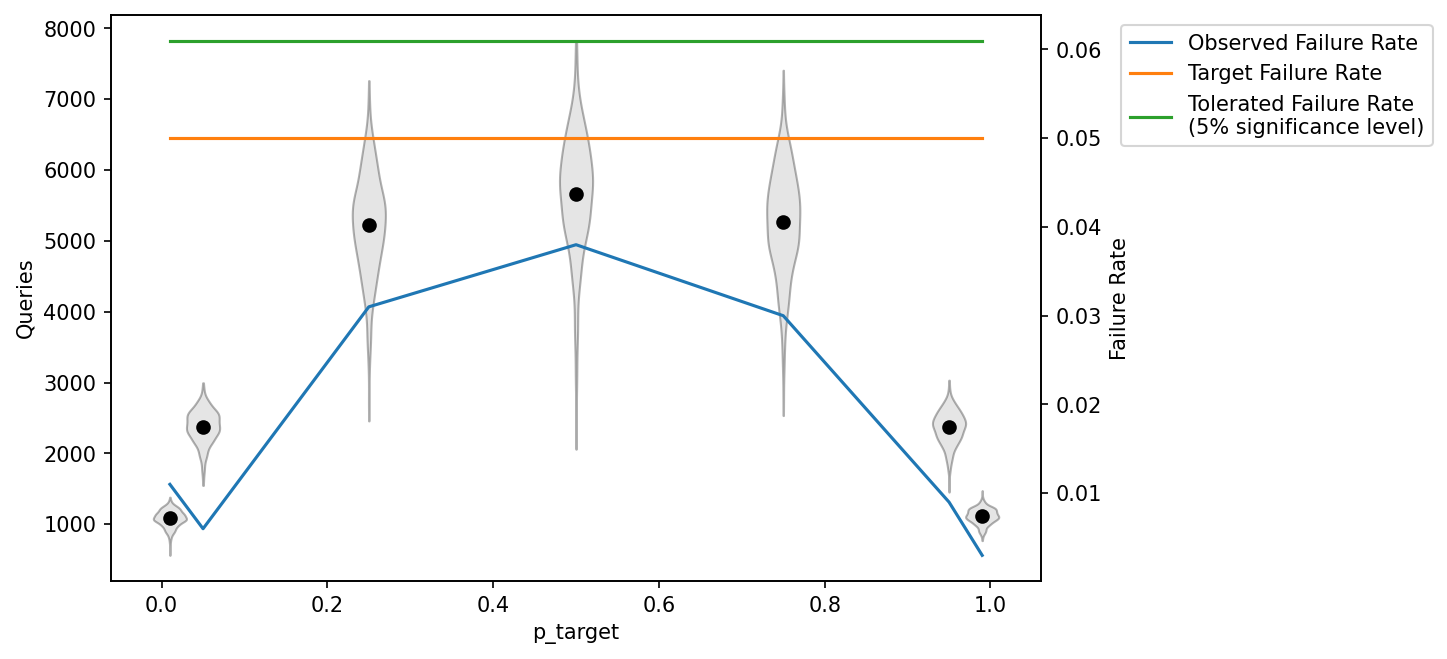

In [7]:
def plot_p_target():
    p_targets = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    data = [get_chebpe_data(p_target, -3, 0.05) for p_target in p_targets]
    plot_queries_and_failures(p_targets, data, "p_target", alphas=0.05)

plot_p_target()

## Dependence on epsilon


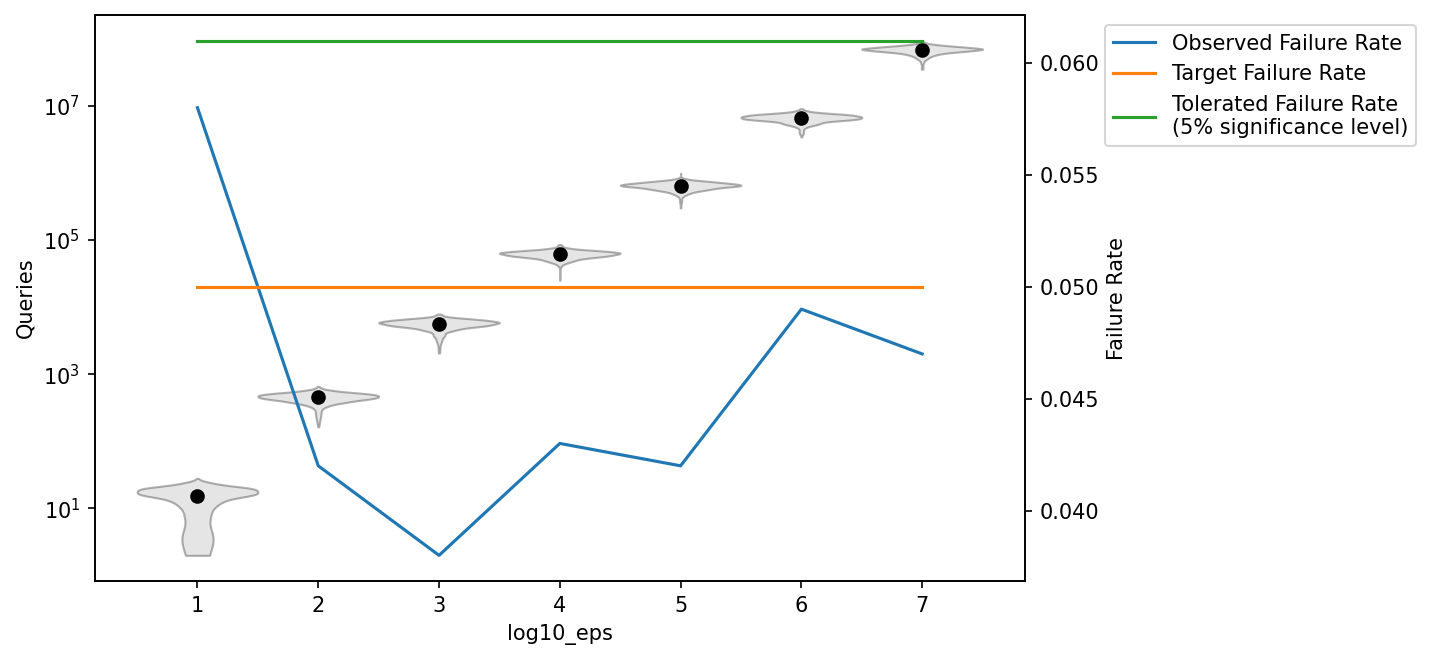

In [8]:
def plot_eps(p_target=0.5):
    minus_log10_epss = [1,2,3,4,5,6,7]
    data = [get_chebpe_data(p_target, -minus_log10_eps, 0.05, r=1.6) for minus_log10_eps in minus_log10_epss]
    plot_queries_and_failures(minus_log10_epss, data, "log10_eps", alphas=0.05, yscale='log')

plot_eps()


## Dependence on alpha

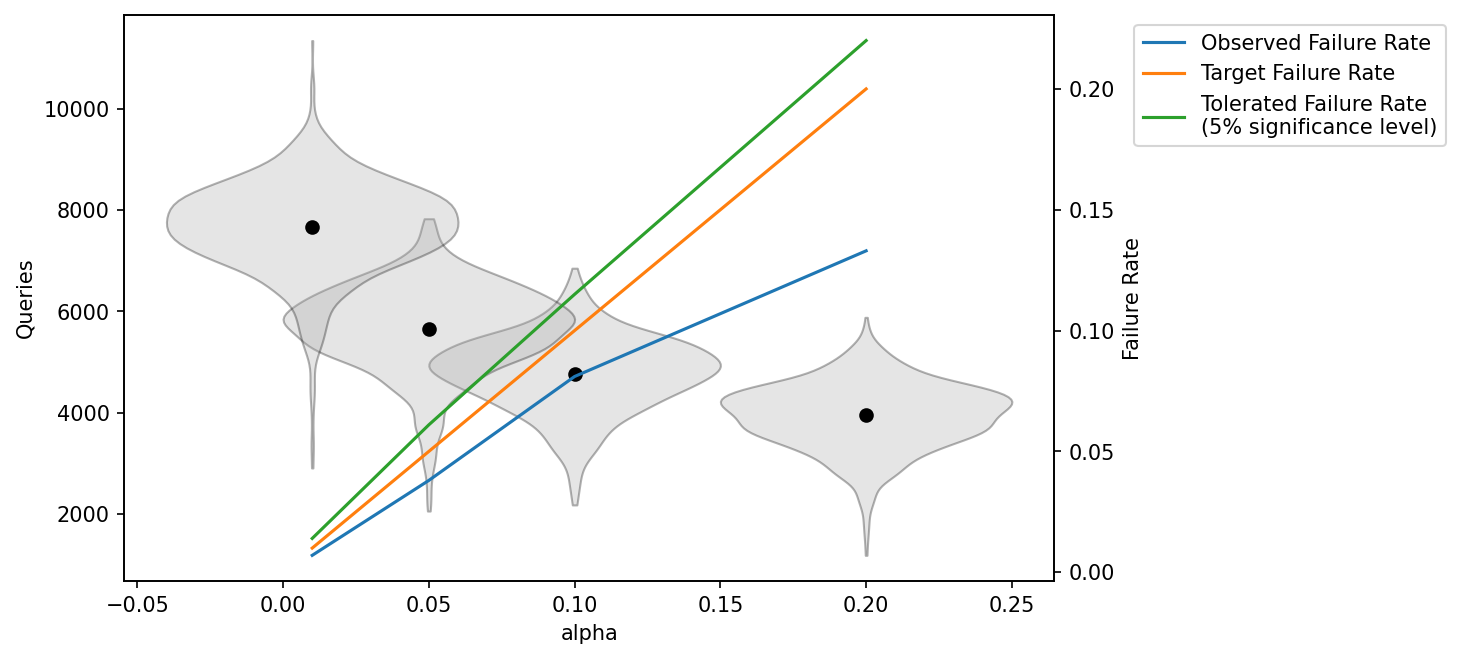

In [9]:
def plot_alpha():
    alphas = [0.2,0.1,0.05,0.01]
    data = [get_chebpe_data(0.5, -3, alpha) for alpha in alphas]
    plot_queries_and_failures(alphas, data, "alpha", alphas=alphas)

plot_alpha()

# Hyperparameter Optimization

## Dependence on nu

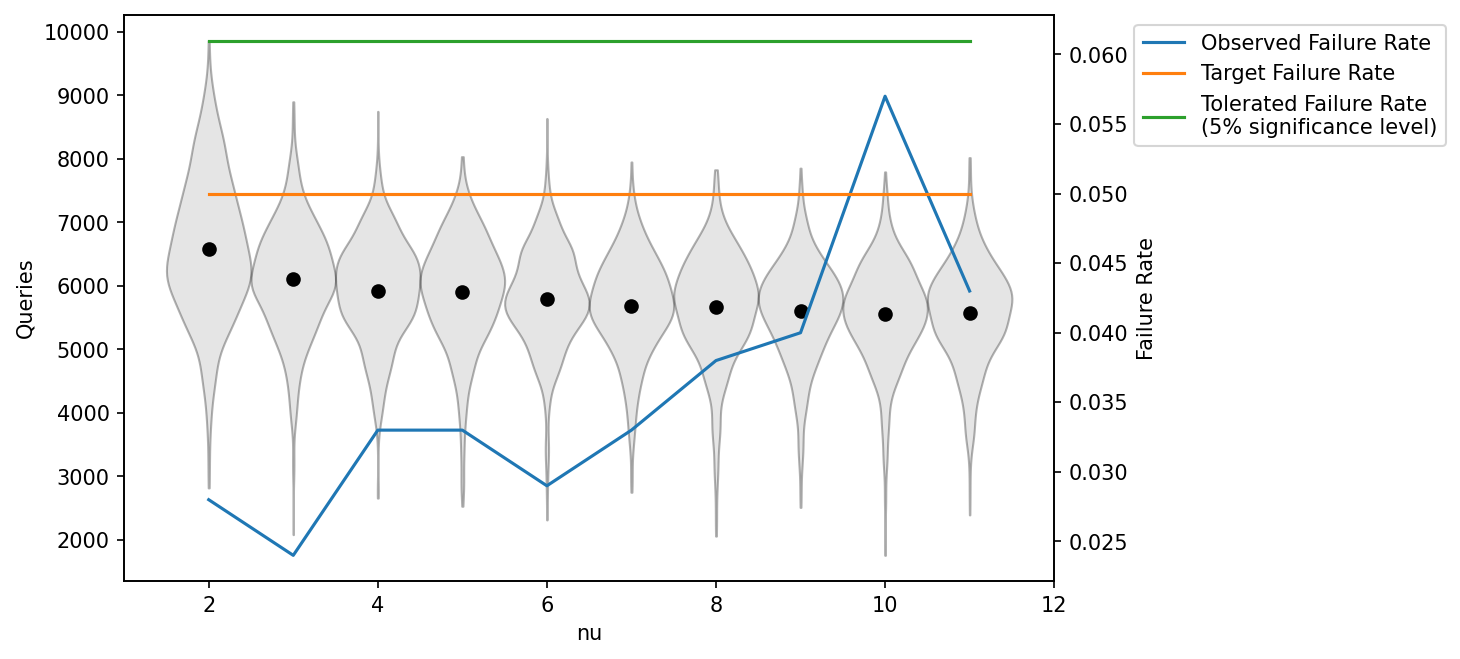

In [10]:
def plot_nu():
    nus = [2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0]
    data = [get_chebpe_data(0.5, -3, 0.05, nu=nu) for nu in nus]
    plot_queries_and_failures(nus, data, "nu", alphas=0.05)

plot_nu()

# Dependence on r

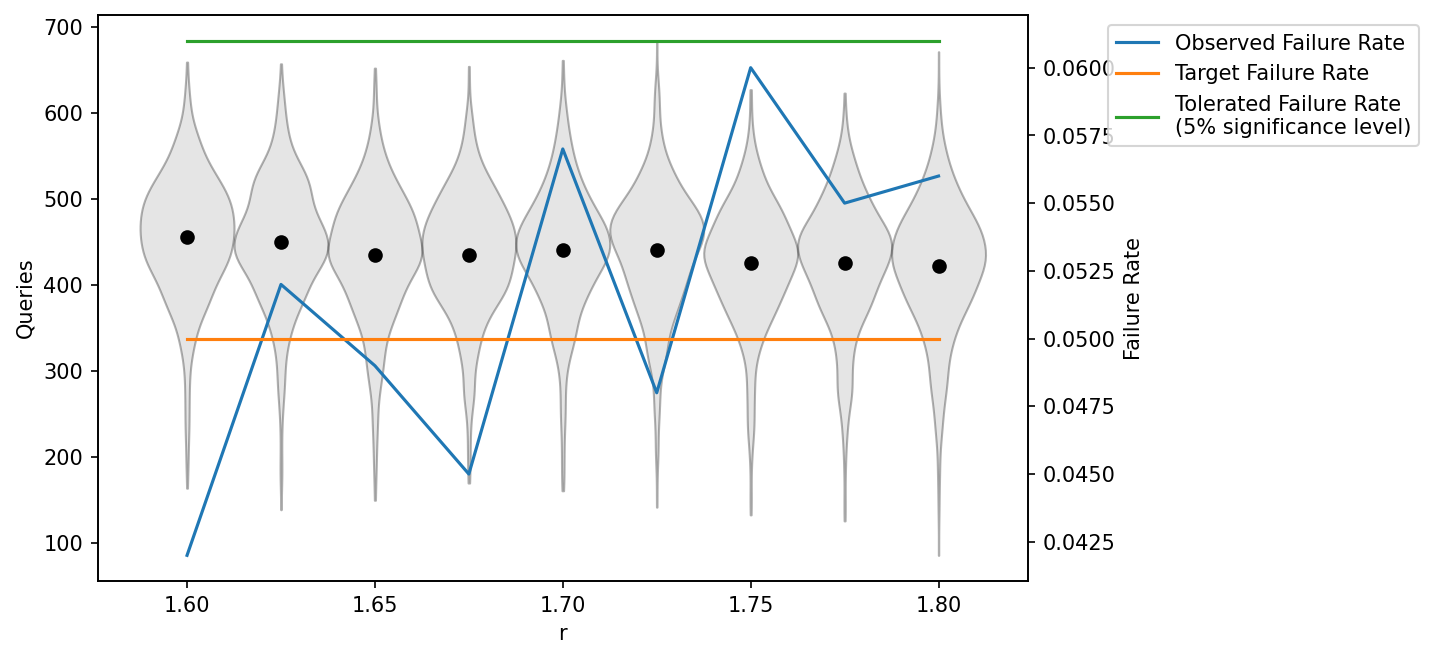

In [11]:
def plot_r():
    rs = [1.6,1.625,1.65,1.675,1.7,1.725,1.75,1.775,1.8]
    data = [get_chebpe_data(0.5, -2, 0.05, r=r) for r in rs]
    plot_queries_and_failures(rs, data, "r", alphas=0.05)

plot_r()

# Dependence on Nshots

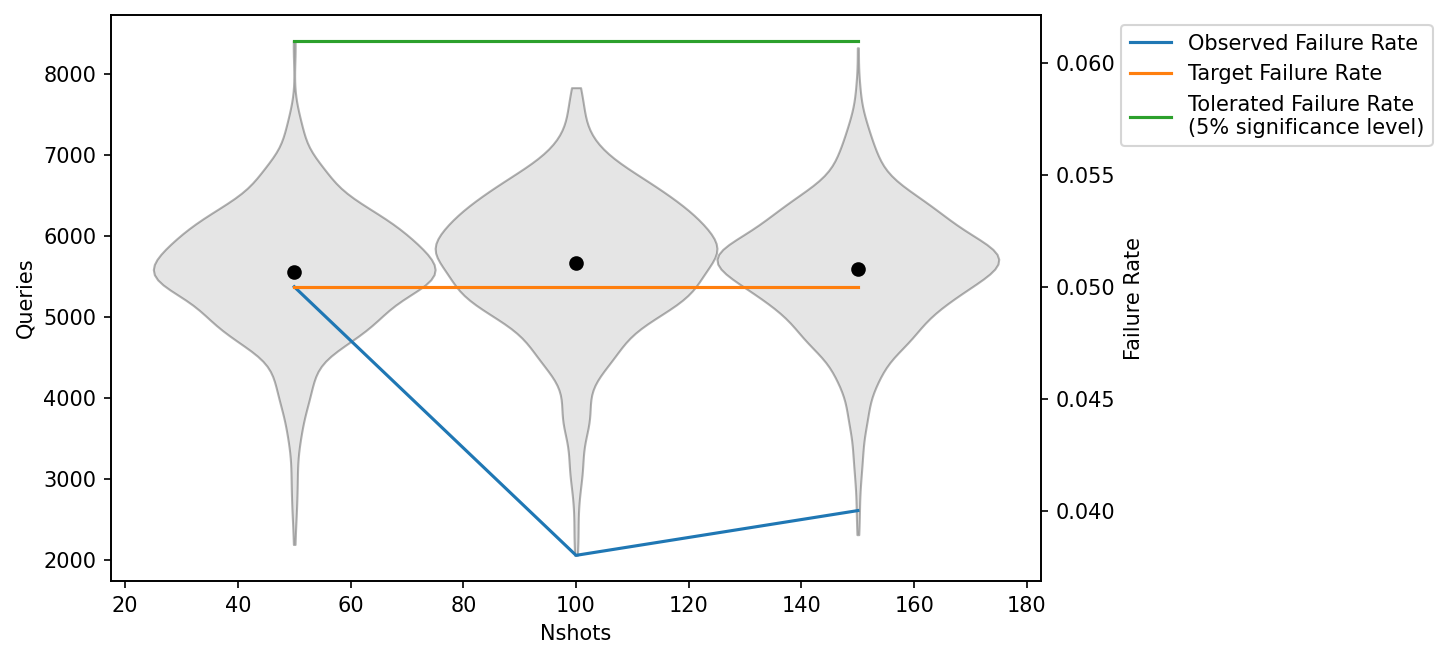

In [12]:
def plot_Nshots():
    Nshotss = [50,100,150]
    data = [get_chebpe_data(0.5, -3, 0.05, Nshots=Nshots) for Nshots in Nshotss]
    plot_queries_and_failures(Nshotss, data, "Nshots", alphas=0.05)

plot_Nshots()